# Impact Of Borrower Features On Loan Performance (Estimated Return)

## Investigation Overview

In this investigation, I wanted to look at borrower features that will have the largest effect on the performance of the loan (Estimated return). The main focus was on a few main variables, Loan Status, IncomeRange, DebtToIncomeRatio, Prosper Rating (Alpha), average credit score* and employment status; as it may potentially have the largest effect on the performance of the loan so makes the most sense.

## Dataset Overview


This notebook explores a dataset containing peer-to-peer loan information of 113,937 loans with 80 variables on each loan from Prosper Funding LLC. The variables are a mix of quantitative variables and categorical variables. Along with the dataset, a feature dictionary describing the variables was also provided [here](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0).

You will find that the file (prosperLoanData.csv) isn't uploaded in the repository since we have added it to the google drive then extracted here in this colab notebook for analysis.

In [9]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('prosperLoanData.csv')

df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [10]:
# creating a copy of the original dataset so that i don't affect the original data set. also, used .info() to see key information about the datset.
loan_copy = df.copy()
loan_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

In [11]:
# na values observed from CreditGrade and EmploymentStatus. replacing these values with "Not available".
na_mask = loan_copy['EmploymentStatus'].isna()
loan_copy.loc[na_mask, 'EmploymentStatus'] = 'Not available'

# repeating the same process for CreditGrade. Replace nan with "Not available". as well as value called "NC", to "No credit".
na_mask_2 = loan_copy['CreditGrade'].isna()
loan_copy.loc[na_mask_2, 'CreditGrade'] = 'Not available'
na_mask_3 = loan_copy['CreditGrade'] == 'NC'
loan_copy.loc[na_mask_3, 'CreditGrade'] = 'No credit'

In [12]:
# in this step, am converting the variables to ordinal variables
# creating a dictionary for categorisation of ordinal variables
ordinal_var_dict = {'ProsperRating (Alpha)': ['HR','E','D','C','B','A','AA'],
                    'CreditGrade':['Not available','No credit','HR','E','D','C','B','A','AA'],
                   'EmploymentStatus': ['Not available','Not employed','Retired','Other','Employed','Part-time','Self-employed','Full-time'],
                    'LoanStatus':['Cancelled','Chargedoff','Defaulted','Past Due (>120 days)',
                                  'Past Due (91-120 days)','Past Due (61-90 days)',
                                  'Past Due (31-60 days)','Past Due (16-30 days)',
                                  'Past Due (1-15 days)','FinalPaymentInProgress',
                                  'Current','Completed']
       
                   }
# utilising a for loop to reduce repetitive code for conversion of variables to ordinal variables
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, 
                                               categories = ordinal_var_dict[var])
    loan_copy[var] = loan_copy[var].astype(ordered_var)

## Distribution of Estimated Return

It appears we have quite a few empty cells since the total number of rows is over 100,000. That had been removed before plotting the distribution of returns.After cleaning the data, here were the key observations:

1.   Most of our loans have an estimated return between 0% and 20%.
2.   Range of returns lie between -18% to 28%.
3.   Largest bin falls right around 12.5%.


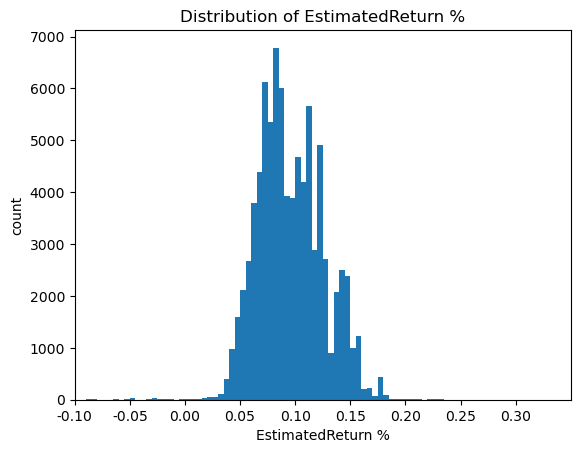

In [13]:
# drop null rows without an estimated return
loan_copy.EstimatedReturn.dropna(axis = 0, inplace = True)

# distribution of EstimatedReturn %
binsize_apr = 0.005
bins_apr = np.arange(-0.15, loan_copy['EstimatedReturn'].max()+binsize_apr, binsize_apr)

plt.hist(data = loan_copy, x = 'EstimatedReturn', bins = bins_apr)
plt.xlabel('EstimatedReturn %')
plt.xlim((-0.10,0.35))
plt.title('Distribution of EstimatedReturn %')
x_ticks = [-0.10,-0.05,0.00,0.05,0.10,0.15,0.20,0.25,0.30]
x_ticks_names = ['-0.10','-0.05','0.00','0.05','0.10','0.15','0.20','0.25','0.30']
plt.xticks(x_ticks, x_ticks_names)

plt.ylabel('count')

plt.show()

#alternative graph plot v2
#plt.figure(figsize = [8,5])
#sns.distplot(df.EstimatedReturn, kde = False, bins = 200)
#plt.xlim(0, .2)
#plt.xlabel('Estimated Return')
#plt.ylabel('Count')
#plt.title('Distribution of Estimated Returns');

## Distribution of Prosper Rating (Alpha)

It appears we have quite a few empty cells since the total number of rows is over 100,000. That had been removed before plotting the distribution of returns.

After cleaning the data, we are seeing the highest frequency from a C Prosper Rating, making up for 21% of the total number of loans. And the lowest frequency from the HR Prosper Rating loans, (making up for 8.2% of the total number of loans.

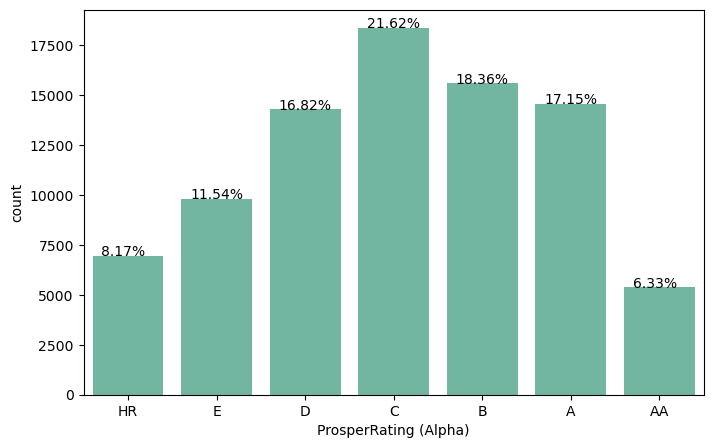

In [14]:
# plot distribution
plt.figure(figsize = [8, 5])
base_color = sns.color_palette("Set2", 1)


plt.xlabel('ProsperRating (Alpha)')
plt.ylabel('Count')
plot = sns.countplot(data = loan_copy, x = 'ProsperRating (Alpha)', palette = base_color)


rating_counts = loan_copy['ProsperRating (Alpha)'].value_counts()
n_loan = loan_copy.shape[0]

#function to add in percentage labels to bar data
#https://gist.github.com/marco-ostaska/9c786c93a46d7a33cfc6299673863f73 function to print values / percentages in bar chart matplotlib
def barplot_values_percent(ax):
    heightlst = []
    for i in ax.patches:
        heightlst.append(i.get_height())
    total = sum(heightlst)
    
    for i in ax.patches:
        x = i.get_x()+0.10 #adjust the numbers (higher numbers = to the right, lower = to the left)
        height = i.get_height()+2.5 #adjust the numbers (higher numbers = up, lower = down)
        value = ("{0:.2f}".format((i.get_height()/total)*100)+'%')
        
        ax.text(x, height, value, fontsize=10,color='black')

barplot_values_percent(plot)

## Estimated Return vs. Prosper Rating (Alpha)

Plotting Estimated Returns vs Propser Rating (Alpha), it was observed that generally, there was a strong negative relationship. The higher the rating, the lower the estimated returns are.

/Users/bryancheong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


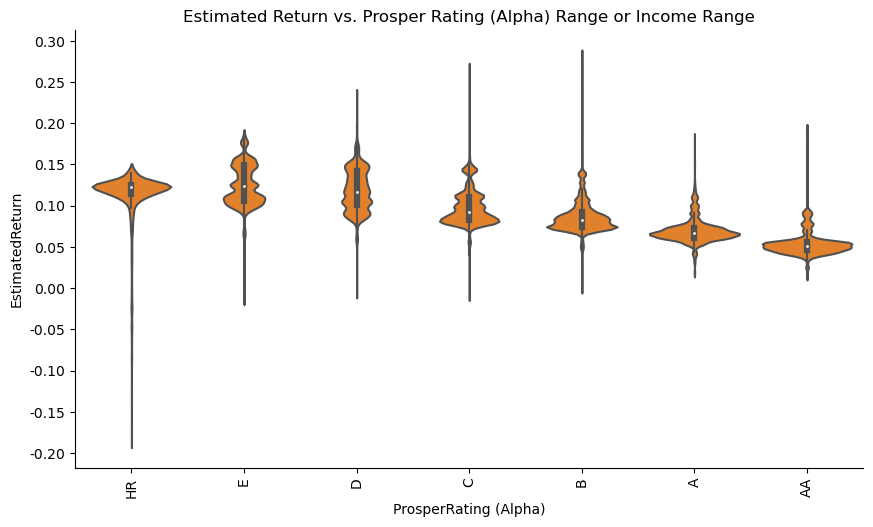

In [15]:
def boxgrid(x,y,**kwargs):
    default_color = sns.color_palette()[1]
    sns.violinplot(x, y, color = default_color)
    y_ticks = [-0.20,-0.15,-0.10,-0.05,0.00,0.05,0.10,0.15,0.20,0.25,0.30]
    y_ticks_names = ['-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.15','0.20','0.25','0.30']
    plt.yticks(y_ticks, y_ticks_names)
    plt.xticks(rotation = 90)
    plt.ylabel('Estimated Return')

g = sns.PairGrid(data = loan_copy, y_vars = 'EstimatedReturn', x_vars = ['ProsperRating (Alpha)'])
plt.title('Estimated Return vs. Prosper Rating (Alpha) Range or Income Range')
g.fig.set_size_inches(12,6)
g.map(boxgrid)
plt.show()

## Estimated Returns vs. Term Duration & Prosper Ratings (Alpha)

For each individual term over every rating, the return decreases as the rating increases. However, diving deeper into loan term length, across all ratings, the longer the term of the loan, the higher the estimated return is.

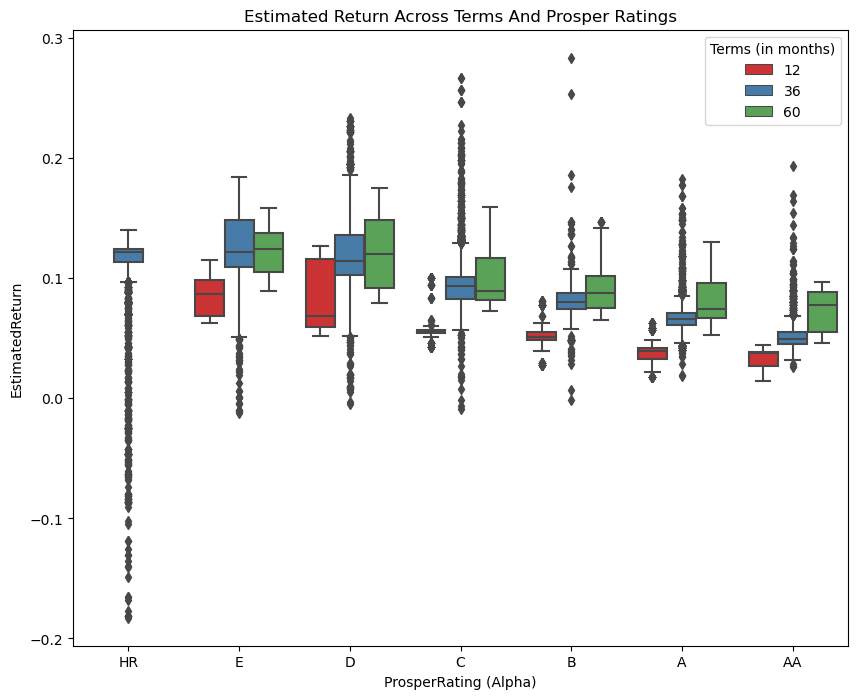

In [16]:
fig = plt.figure(figsize = [10, 8])
ax = sns.boxplot(x='ProsperRating (Alpha)', y='EstimatedReturn', hue='Term',
                 data=loan_copy, palette="Set1")
plt.title('Estimated Return Across Terms And Prosper Ratings')
plt.legend(title = 'Terms (in months)');

## EstimatedReturn vs. Employment Status & Prosper Ratings

We can see how Employment Status affects estimated returns price by through this chart where for E & D borrowers, retired workers are seeing higher estimated return vs. unemployed workers. For C to AA, unemployed workers tend to have the higest rate of return.

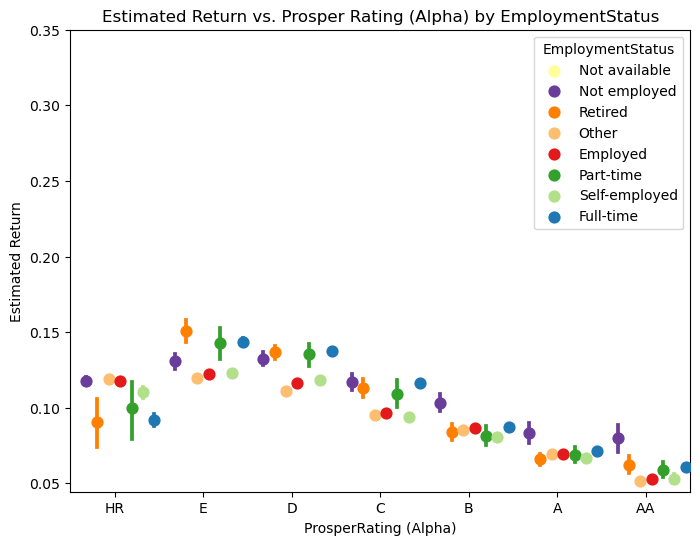

In [17]:
## Example of nominal data ##
fig = plt.figure(figsize = [8,6])
ax = sns.pointplot(data = loan_copy, x = 'ProsperRating (Alpha)', y = 'EstimatedReturn', hue = 'EmploymentStatus',
           palette = 'Paired_r', linestyles = '', dodge = 0.9)
plt.title('Estimated Return vs. Prosper Rating (Alpha) by EmploymentStatus')
plt.ylabel('Estimated Return')
plt.yticks([0.05,0.10,0.15,0.20,0.25,0.30,0.35], ['0.05','0.10','0.15','0.20','0.25','0.30','0.35'])
ax.set_yticklabels([],minor = True)
plt.show();

## EstimatedReturn vs. Income Range & Credit Score

Diving into other cuts of categorical data like Income Range & Credit Score, across income ranges $25,000 to $100,000+, most of the dark color areas are in a downward trending pattern, meaning that a higher credit score leads to lower estimated returns. For lower income ranges however, the pattern is not as obvious and the heatmap is more scattered.

In [18]:
# create a new variable that averages the upper and lower range of the credit score.
loan_copy['average_credit_score'] = (loan_copy['CreditScoreRangeLower'] + loan_copy['CreditScoreRangeUpper'])/2

/Users/bryancheong/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


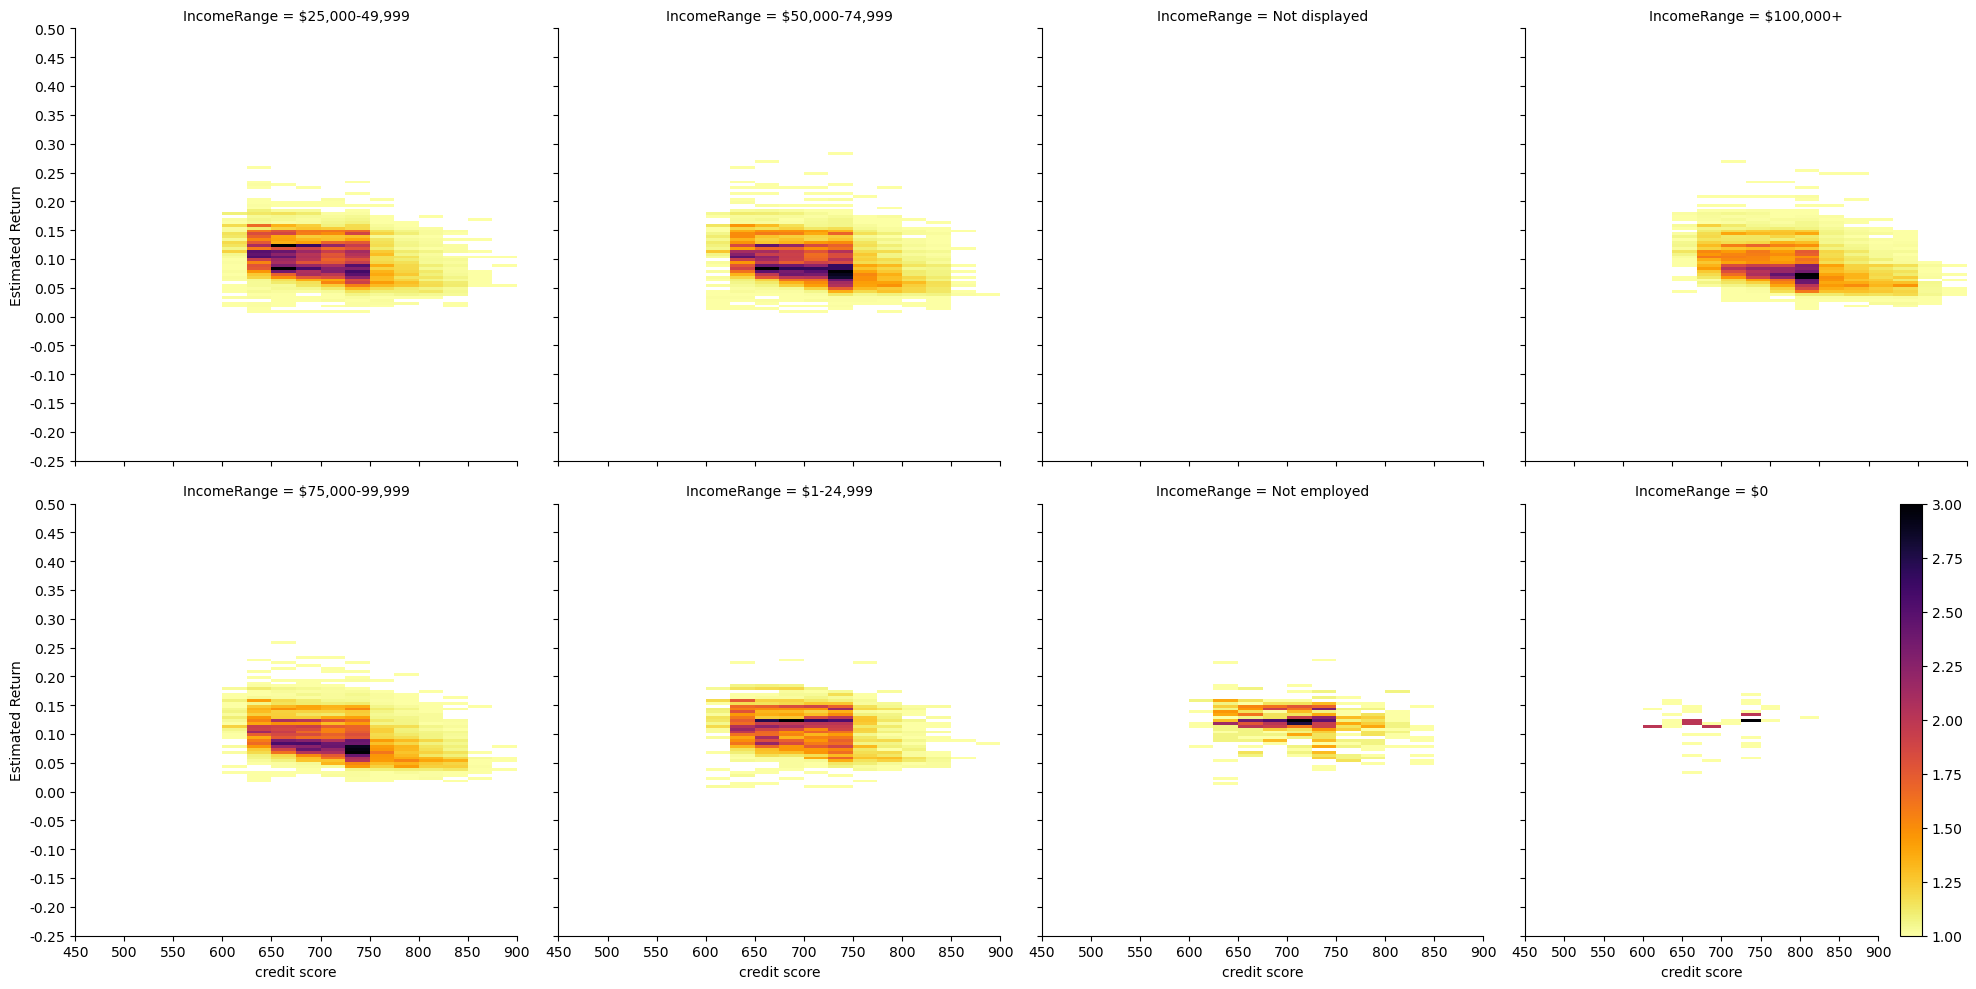

In [19]:
def hist2dgrid(x, y, **kwargs):
    palette = kwargs.pop('color')
    binsize_x = 25
    bins_x = np.arange(450, loan_copy['average_credit_score'].max()+binsize_x, binsize_x)
    binsize_y = 0.005
    bins_y = np.arange(0.006, loan_copy['EstimatedReturn'].max()+binsize_y, binsize_y)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 0.5)
    x_ticks = np.arange(450, 900+50, 50)
    x_ticks_names = ['450','500','550','600','650','700','750','800','850','900']
    y_ticks = [-0.25,-0.20,-0.15,-0.10,-0.05,0.0,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]
    y_ticks_name = ['-0.25','-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.45','0.50']
    #    y_ticks_names = y_ticks.astype('str')
    plt.xticks(x_ticks,x_ticks_names )
    plt.yticks(y_ticks,y_ticks_name)

# create faceted heat maps on levels of the color variable

g = sns.FacetGrid(data = loan_copy, col = 'IncomeRange', col_wrap = 4, size = 5,
                 xlim = [450, 900], ylim = [-0.30,0.30])
g.map(hist2dgrid, 'average_credit_score', 'EstimatedReturn', color = 'inferno_r')

g.set_xlabels('credit score')
g.set_ylabels('Estimated Return')
plt.colorbar()
plt.show()

In [23]:
!jupyter nbconvert Part2.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] WARNING | pattern 'Part2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execu